In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from tqdm.auto import tqdm


SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Teacher model

In [33]:

from models import Teacher
                
teacher = Teacher().to(device)
teacher.init_weights()

In [34]:
# The covariates are random uniform in [0,2] of 100 dimensions
X = np.random.uniform(0, 2, (60000, 100))
X = torch.tensor(X, dtype=torch.float32).to(device)
y = teacher(X)

# Create a TensorDataset
from torch.utils.data import TensorDataset, DataLoader
test_set = TensorDataset(
    X, y
)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False)

### Student models

In [35]:
batch_size = 128

def sample_batch():
    X_batch = np.random.uniform(0, 2, (128, 100))
    X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
    
    return X_batch, teacher(X_batch)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(teacher.parameters(), lr=1e-3, weight_decay=1e-3)

In [36]:
# Train the under-parametrized student
from models import StudentU, StudentE

student = StudentE().to(device)
student.init_weights()

# Train the student
n_steps = 1000

train_losses = []

for step in tqdm(range(n_steps)):
    X_batch, y_batch = sample_batch()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = student(X_batch)
    
    # Compute the loss
    loss = criterion(y_pred, y_batch)
    
    # Backward pass
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(student.parameters(), 1)
    
    # Optimize
    optimizer.step()
    
    train_losses.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

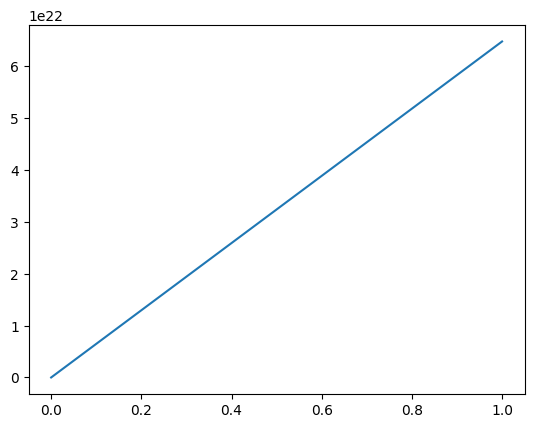

In [37]:
plt.plot(train_losses)